<a href="https://colab.research.google.com/github/samantha-isaac/Emotion-Detection-in-Images-and-Music-Pairing-Through-AI/blob/main/CNN_Baseline_Face_Expressions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is the compilation of all the code used for the Project: Emotion Detection in Images and Music Pairing Through AI
### By: Samantha Georgina Isaac Munoz


# Baseline CNNs for Face Expressions dataset
Samantha Isaac

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Flatten, Dense, MaxPooling2D, Conv2D, Input, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
# This is to mount Drive to this project
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Connect to My Drive
%cd /content/drive/My Drive/

/content/drive/My Drive


In [ ]:
# Paths to the folder for the Face expressions dataset
training_dataset_folder = '/content/drive/MyDrive/Dissertation/Code/Data_Faces/Training'
testing_dataset_folder = '/content/drive/MyDrive/Dissertation/Code/Data_Faces/Testing'

# This function helps load the images and assigns as the labels the name of the correspodning folder
# References used for the function with os: https://docs.python.org/3/library/os.html
def load_images_and_labels(folder_path):
    images = []
    labels = []
    sub_folders = os.listdir(folder_path)

    for sub_folder in sub_folders:
        label = sub_folder  # In here is where the name of the sub folders is taken as the label
        image_files = os.listdir(os.path.join(folder_path, sub_folder))

        for image_file in image_files:
            image_path = os.path.join(folder_path, sub_folder, image_file)
            # This is to load the images in grey scale
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) # Reference for this: https://docs.opencv.org/4.x/d4/da8/group__imgcodecs.html
            if image is not None:
                images.append(image)
                labels.append(label)

    return images, labels

In [ ]:
# To load training images and labels
training_images, training_labels = load_images_and_labels(training_dataset_folder)

# to load testing images and labels
testing_images, testing_labels = load_images_and_labels(testing_dataset_folder)

Unique labels in the training set: {'Angry', 'Sad', 'Happy', 'Fear', 'Neutral'}
Unique labels in the test set: {'Angry', 'Sad', 'Happy', 'Fear', 'Neutral'}

Number of images per class in the training set:
Angry: 3995
Fear: 4097
Happy: 7215
Neutral: 4965
Sad: 4830

Number of images per class in the testing set:
Angry: 958
Fear: 1020
Happy: 1774
Neutral: 1233
Sad: 1247

Showing images of the class: Angry

Showing images of the class: Sad

Showing images of the class: Happy

Showing images of the class: Fear

Showing images of the class: Neutral

Showing images of the class: Angry

Showing images of the class: Sad

Showing images of the class: Happy

Showing images of the class: Fear

Showing images of the class: Neutral


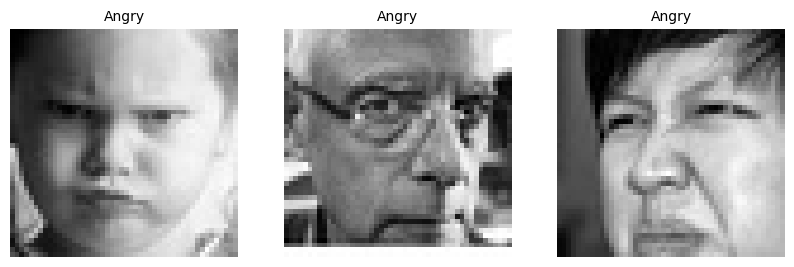

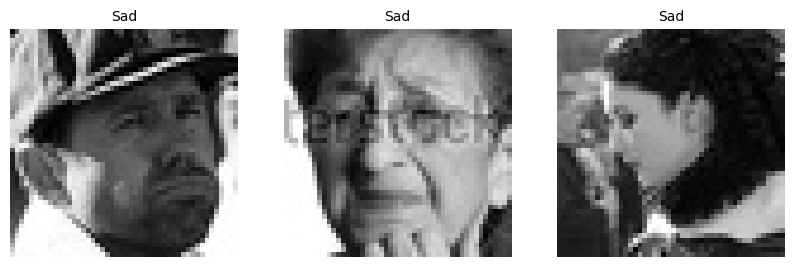

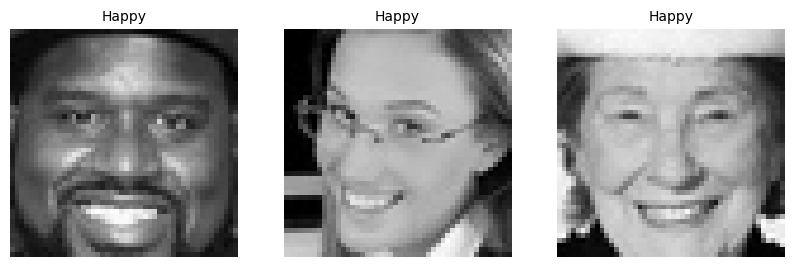

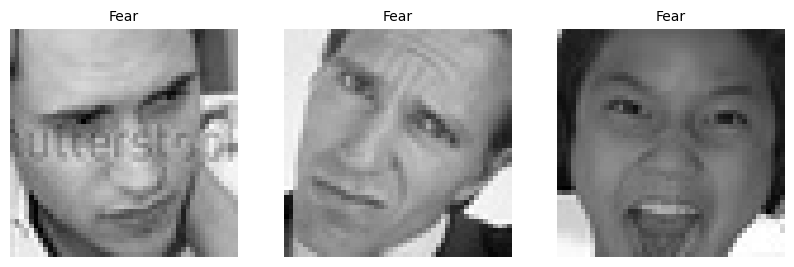

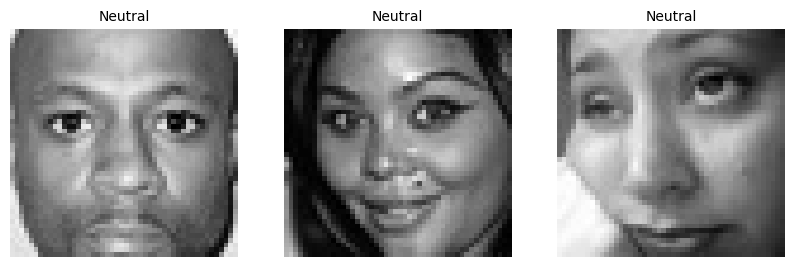

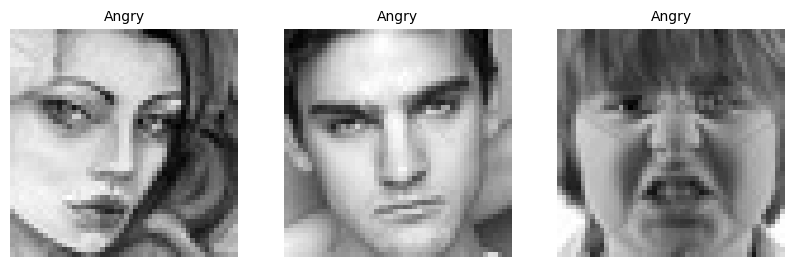

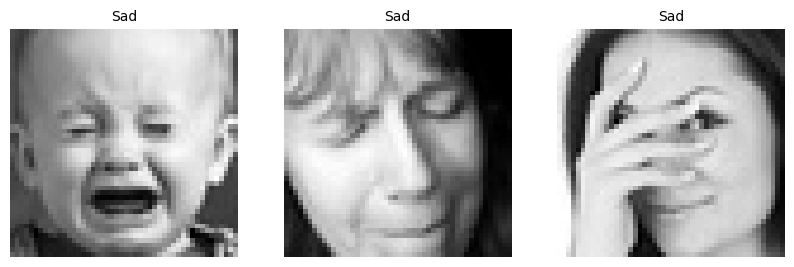

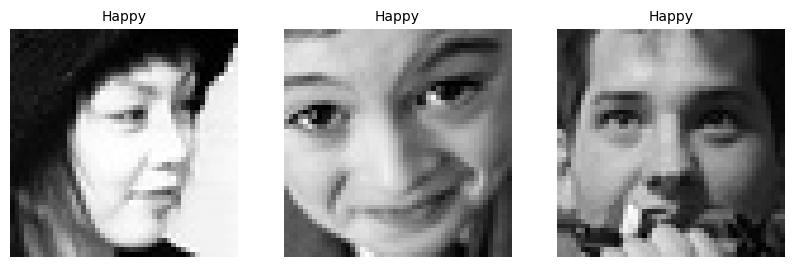

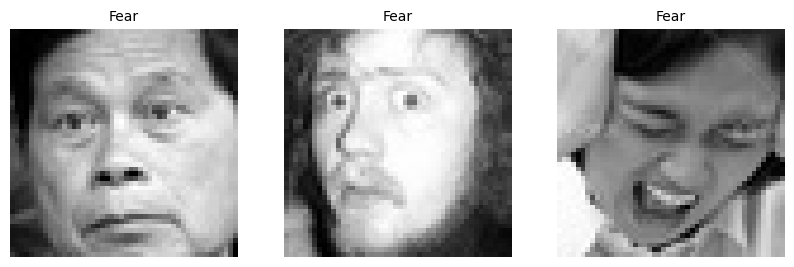

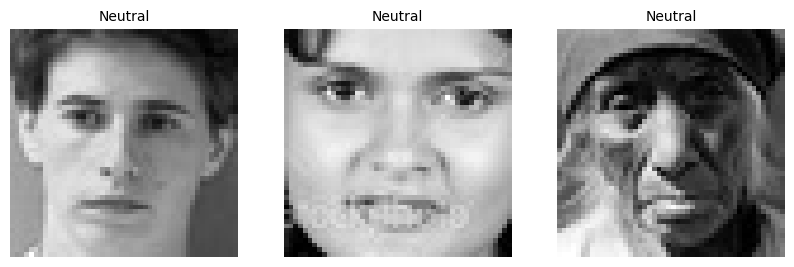

In [ ]:
# Convert tag lists into sets to view unique tags
training_labels_unique = set(training_labels)
testing_labels_unique = set(testing_labels)

# I print them to verify that the labels were properly assigned
print("Unique labels in the training set:", training_labels_unique)
print("Unique labels in the test set:", testing_labels_unique)

# To verify the total amount of images per label. Reference from: https://docs.python.org/3/library/collections.html#collections.Counter
training_labels_count = Counter(training_labels)
testing_labels_count = Counter(testing_labels)

print("\nNumber of images per class in the training set:")
for label, count in training_labels_count.items():
    print(f"{label}: {count}")

print("\nNumber of images per class in the testing set:")
for label, count in testing_labels_count.items():
    print(f"{label}: {count}")

# This is to show a few images to visually verify the images and the labels
def show_images_per_class(images, labels, clase, num_imagenes=3):
    print(f"\nShowing images of the class: {clase}") # This line was added to explicitatly indicate which images are being shown
    fig, axes = plt.subplots(1, num_imagenes, figsize = (10, 3)) # Reference from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
    # This is to create a list of the specific images
    imagenes_clase = [img for img, lbl in zip(images, labels) if lbl == clase]

# This is to iterate and take only the specific number of images, which is 3
    for i in range(num_imagenes):
        if i < len(imagenes_clase):
            axes[i].imshow(imagenes_clase[i], cmap = 'gray') # To show the images in grey scale
            axes[i].axis('off') # To hide the number and borders of the axis. Reference from: https://www.geeksforgeeks.org/how-to-turn-off-the-axes-for-subplots-in-matplotlib/
            # To add title with the corresponding label of each image
            axes[i].set_title(clase, fontsize = 10)
        else:
            axes[i].axis('off')

# It does this for both training and testing dataset
for label in training_labels_unique:
    show_images_per_class(training_images, training_labels, label)

for label in testing_labels_unique:
    show_images_per_class(testing_images, testing_labels, label)

In [ ]:
# To crerate a dictionary that assigns a numeric value to each label
label_map = {label: idx for idx, label in enumerate(set(training_labels))}
# For both training and testing dataset, it replace the label with the correspodning numeric value stablich in the line above
training_labels_numeric = [label_map[label] for label in training_labels]
testing_labels_numeric = [label_map[label] for label in testing_labels]

# Just to verify the numeric values of the corresponding labels
print("Contents of the label_map dictionary:")
for label, index in label_map.items():
    print(f"'{label}': {index}")

Contents of the label_map dictionary:
'Angry': 0
'Sad': 1
'Happy': 2
'Fear': 3
'Neutral': 4


In [ ]:
# Convert labels to one-hot encoding. Reference from: https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
num_classes = len(label_map)
training_labels_y_encoded = to_categorical(training_labels_numeric, num_classes=num_classes)
testing_labels_y_encoded = to_categorical(testing_labels_numeric, num_classes=num_classes)

# To normalize and to convert in arrays of NumPy. Reference from: https://numpy.org/doc/stable/reference/generated/numpy.array.html
training_images_x = np.array(training_images) / 255.0
testing_images_x = np.array(testing_images) / 255.0

# This is to reshape images to add channel dimension. Reference: https://numpy.org/doc/stable/reference/generated/numpy.reshape.html
training_images_x = training_images_x.reshape(-1, 48, 48, 1)
testing_images_x = testing_images_x.reshape(-1, 48, 48, 1)

# This was an extra added to improve the generalisability of the model, generating new modified versions of the images
datagen = ImageDataGenerator(
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True
)

datagen.fit(training_images_x)

In [ ]:
# Stablish the structure of the CNN model. Used a reference for most of the structure of the models
# the project of: https://medium.com/@skillcate/emotion-detection-model-using-cnn-a-complete-guide-831db1421fael
input = Input(shape = (48, 48, 1))
conv1 = Conv2D(16, (3, 3), padding = 'same', activation = 'relu')(input)
pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)

conv2 = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(pool1)
pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)

flatten = Flatten()(pool2)
dense_1 = Dense(64, activation = 'relu')(flatten)
output = Dense(num_classes, activation = "softmax")(dense_1)

In [ ]:
# To compile the model. Reference: https://www.tensorflow.org/api_docs/python/tf/keras/Model
model = Model(inputs = input, outputs = output)
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ['accuracy'])
model.summary() # I get a summary of the model architecture. Reference: https://stackoverflow.com/questions/36946671/keras-model-summary-result-understanding-the-of-parameters

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 4608)              0     

In [ ]:
# To train the model, and I specdify the parameters to use. Reference: https://stackoverflow.com/questions/37973005/what-do-model-predict-and-model-fit-do
history = model.fit(
    training_images_x,
    training_labels_y_encoded,
    validation_data = (testing_images_x, testing_labels_y_encoded),
    epochs = 50,
    batch_size = 32
)

Epoch 1/50
785/785 [==============================] - 9s 5ms/step - loss: 1.4488 - accuracy: 0.3852 - val_loss: 1.3556 - val_accuracy: 0.4368
Epoch 2/50
785/785 [==============================] - 3s 4ms/step - loss: 1.2873 - accuracy: 0.4708 - val_loss: 1.2800 - val_accuracy: 0.4783
Epoch 3/50
785/785 [==============================] - 3s 4ms/step - loss: 1.2077 - accuracy: 0.5074 - val_loss: 1.2225 - val_accuracy: 0.4966
Epoch 4/50
785/785 [==============================] - 3s 4ms/step - loss: 1.1458 - accuracy: 0.5399 - val_loss: 1.2097 - val_accuracy: 0.5056
Epoch 5/50
785/785 [==============================] - 3s 4ms/step - loss: 1.0805 - accuracy: 0.5685 - val_loss: 1.1876 - val_accuracy: 0.5127
Epoch 6/50
785/785 [==============================] - 3s 4ms/step - loss: 1.0175 - accuracy: 0.5966 - val_loss: 1.1831 - val_accuracy: 0.5265
Epoch 7/50
785/785 [==============================] - 3s 4ms/step - loss: 0.9503 - accuracy: 0.6286 - val_loss: 1.2182 - val_accuracy: 0.5252
Epoch 

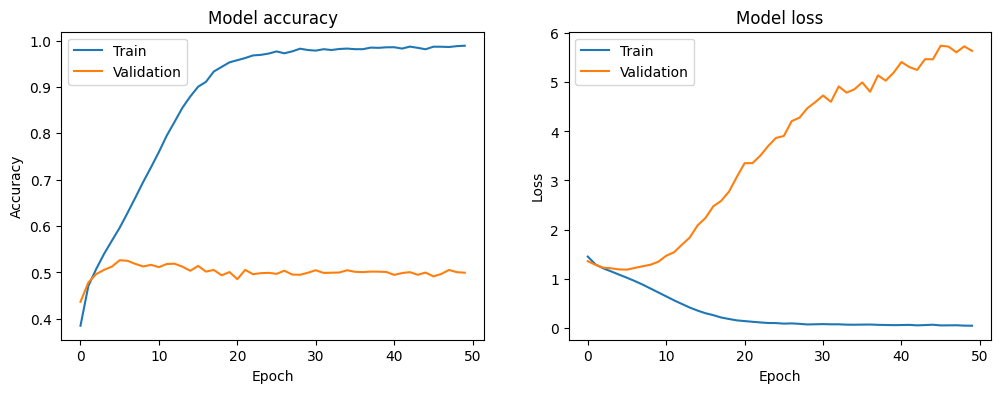

In [ ]:
# This is to visualise the model throughout the training, where accuracy and loss are shown for both training sets
# Reference: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show();

195/195 [==============================] - 0s 2ms/step


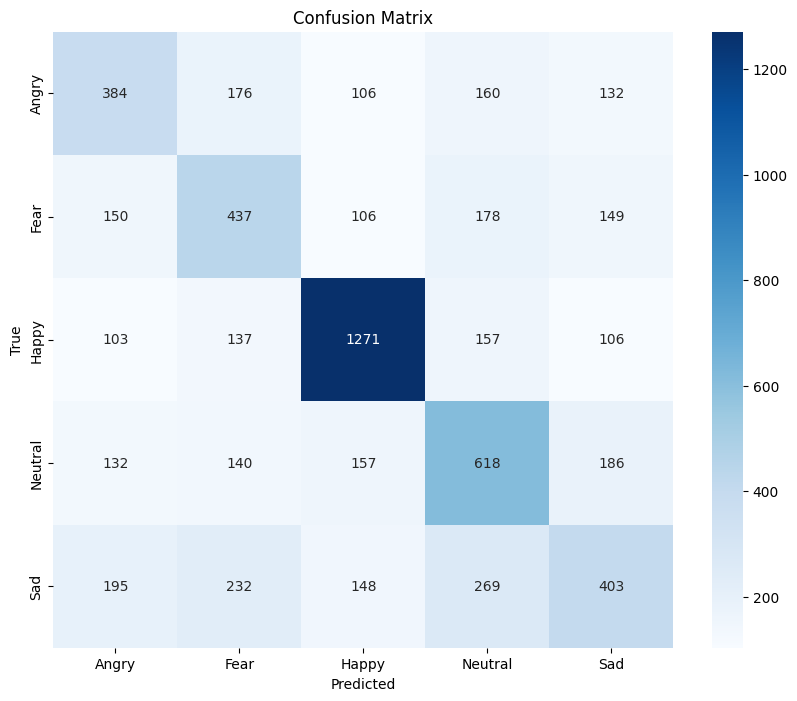

Clasification report:
              precision    recall  f1-score   support

       Angry       0.40      0.40      0.40       958
        Fear       0.39      0.43      0.41      1020
       Happy       0.71      0.72      0.71      1774
     Neutral       0.45      0.50      0.47      1233
         Sad       0.41      0.32      0.36      1247

    accuracy                           0.50      6232
   macro avg       0.47      0.47      0.47      6232
weighted avg       0.50      0.50      0.50      6232



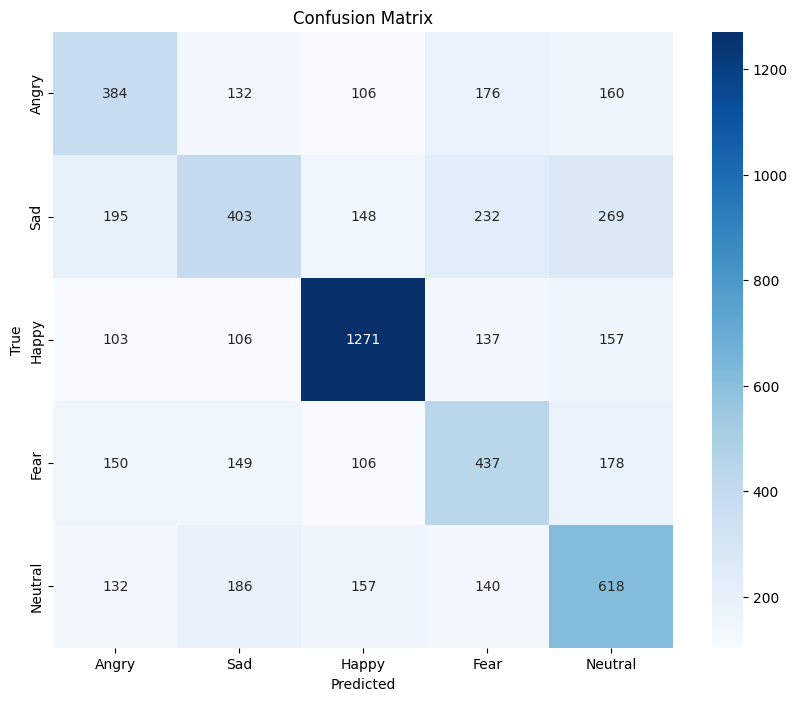

Clasification report:
              precision    recall  f1-score   support

       Angry       0.40      0.40      0.40       958
         Sad       0.41      0.32      0.36      1247
       Happy       0.71      0.72      0.71      1774
        Fear       0.39      0.43      0.41      1020
     Neutral       0.45      0.50      0.47      1233

    accuracy                           0.50      6232
   macro avg       0.47      0.47      0.47      6232
weighted avg       0.50      0.50      0.50      6232



In [ ]:
# This is to evaluate as well the performance of the model with a confusion matrix and a clasification report
# This is for the model to make prediction on the testing images. Reference: https://www.tensorflow.org/api_docs/python/tf/keras/Model
y_pred = model.predict(testing_images_x)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = np.argmax(testing_labels_y_encoded, axis = 1)
y_pred = model.predict(testing_images_x)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = np.argmax(testing_labels_y_encoded, axis = 1)

# Convert the numeric labels back to text labels
index_to_label = {v: k for k, v in label_map.items()}
y_true_labels = [index_to_label[i] for i in y_true]
y_pred_labels = [index_to_label[i] for i in y_pred_classes]

# Define a consistent order for the labels, which is in alphabetical order
label_order = sorted(list(label_map.keys()))

# This is for the confusion matrix. Reference: https://proclusacademy.com/blog/practical/confusion-matrix-accuracy-sklearn-seaborn/
cm = confusion_matrix(y_true_labels, y_pred_labels, labels = label_order)

plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True,
            fmt = 'd',
            cmap = 'Blues',
            xticklabels = label_order,
            yticklabels = label_order)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show();

# Show classification report
print("Clasification report:")
print(classification_report(y_true, y_pred_classes, target_names = label_map.keys()));